In [1]:
import os
import sys
import torch
from torch.utils.data import DataLoader
from torchvision.transforms.functional import normalize, to_pil_image
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.insert(0, parent_dir)

import datasets
from models import get_model
from utils import resize_density_map

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset_name = "nwpu"
split = "val"

model_info_path = os.path.join(parent_dir, "checkpoints", "nwpu", "ebc_b_best", "best_mae.pth")

model = get_model(model_info_path)

model = model.to(device)
model.eval()

CLIP_EBC(
  (backbone): ConvNeXt(
    (stem): Sequential(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (stage0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Linear(in_features=512, out_features=128, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padd

In [2]:
dataset = datasets.Crowd(dataset=dataset_name, split=split, sigma=8, return_filename=True)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0, collate_fn=datasets.collate_fn)
data_iter = iter(dataloader)
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
alpha = 0.8

GT Count: 1307
Pred Count: 1305.81


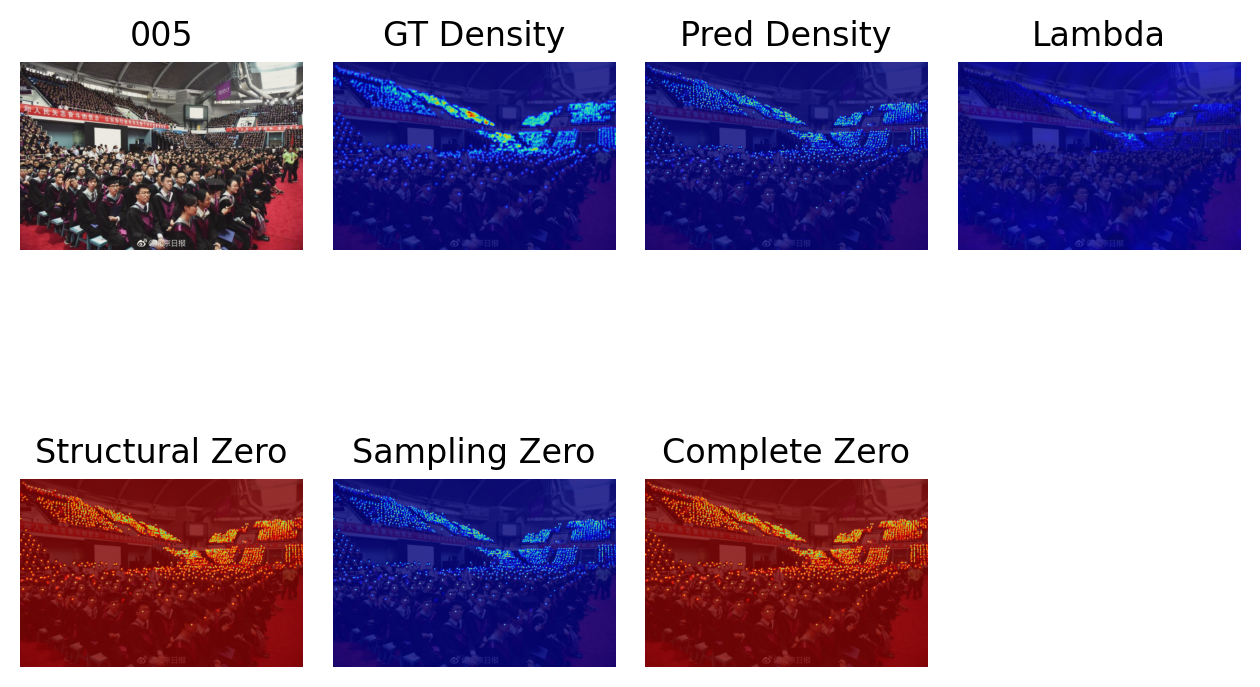

MAE: 1.19, NAE: 0.09%


In [7]:
idx = 4

image, points, density, image_name = dataset[idx]
image_height, image_width = image.shape[-2:]
image = image.to(device)

with torch.no_grad():
    image_feats = model.backbone(image)
    # image_feats = F.normalize(image_feats.permute(0, 2, 3, 1), p=2, dim=-1)  # shape (B, H, W, C)
    pi_image_feats, lambda_image_feats = model.pi_head(image_feats), model.lambda_head(image_feats)
    pi_image_feats = F.normalize(pi_image_feats.permute(0, 2, 3, 1), p=2, dim=-1)  # shape (B, H, W, C)
    lambda_image_feats = F.normalize(lambda_image_feats.permute(0, 2, 3, 1), p=2, dim=-1)  # shape (B, H, W, C)

    pi_text_feats, lambda_text_feats = model.pi_text_feats, model.lambda_text_feats
    pi_logit_scale, lambda_logit_scale = model.pi_logit_scale.exp(), model.lambda_logit_scale.exp()

    pi_logit_map = pi_logit_scale * pi_image_feats @ pi_text_feats.t()  # (B, H, W, 2), logits per image
    lambda_logit_map = lambda_logit_scale * lambda_image_feats @ lambda_text_feats.t()  # (B, H, W, N - 1), logits per image

    pi_logit_map =  pi_logit_map.permute(0, 3, 1, 2)  # (B, 2, H, W)
    lambda_logit_map = lambda_logit_map.permute(0, 3, 1, 2)  # (B, N - 1, H, W)

    lambda_map = (lambda_logit_map.softmax(dim=1) * model.bin_centers[:, 1:]).sum(dim=1, keepdim=True)  # (B, 1, H, W)
    
    # pi_logit_map.softmax(dim=1)[:, 0] is the probability of zeros
    den_map = pi_logit_map.softmax(dim=1)[:, 1:] * lambda_map # (B, 1, H, W)
    count = den_map.sum().item()  # total count

    pi_map = pi_logit_map.softmax(dim=1)[:, 0:1]  # (B, 1, H, W)

    den_map = F.interpolate(den_map, size=(image_height, image_width), mode="bilinear", align_corners=False)
    pi_map = F.interpolate(pi_map, size=(image_height, image_width), mode="bilinear", align_corners=False)
    lambda_map = F.interpolate(lambda_map, size=(image_height, image_width), mode="bilinear", align_corners=False)


image = normalize(image, mean=(0., 0., 0.), std=(1. / std[0], 1. / std[1], 1. / std[2]))
image = normalize(image, mean=(-mean[0], -mean[1], -mean[2]), std=(1., 1., 1.))
image = to_pil_image(image.squeeze(0))

density = density.squeeze().cpu().numpy()
points = points[0]
den_map = den_map.squeeze().cpu().numpy()
pi_map = pi_map.squeeze().cpu().numpy()
lambda_map = lambda_map.squeeze().cpu().numpy()
image_name = image_name[0].split(".")[0]

fig, axes = plt.subplots(2, 4, dpi=200, tight_layout=True, frameon=False)
axes = axes.flatten()

axes[0].imshow(image)
# Optional: plot the ground truth points
# if len(points) > 0:
#     axes[0].scatter(points[:, 0], points[:, 1], s=1, c="white")
axes[0].axis("off")
axes[0].set_title(f"{image_name}")
print(f"GT Count: {len(points)}")

axes[1].imshow(image)
axes[1].imshow(density, cmap="jet", alpha=alpha)
axes[1].axis("off")
axes[1].set_title(f"GT Density")

axes[2].imshow(image)
axes[2].imshow(den_map, cmap="jet", alpha=alpha)
axes[2].axis("off")
axes[2].set_title(f"Pred Density")
print(f"Pred Count: {count:.2f}")

axes[3].imshow(image)
axes[3].imshow(lambda_map, cmap="jet", alpha=alpha)
axes[3].axis("off")
axes[3].set_title("Lambda")

axes[4].imshow(image)
axes[4].imshow(pi_map, cmap="jet", alpha=alpha)
axes[4].axis("off")
axes[4].set_title("Structural Zero")

axes[5].imshow(image)
axes[5].imshow((1 - pi_map) * np.exp(-lambda_map), cmap="jet", alpha=alpha)
axes[5].axis("off")
axes[5].set_title("Sampling Zero")

axes[6].imshow(image)
axes[6].imshow(pi_map + (1 - pi_map) * np.exp(-lambda_map), cmap="jet", alpha=alpha)
axes[6].axis("off")
axes[6].set_title("Complete Zero")

axes[7].set_visible(False)
plt.show()

mae = abs(count - len(points))
nae = mae / len(points) if len(points) > 0 else 0.0
print(f"MAE: {mae:.2f}, NAE: {nae:.2%}")